Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 22.  Winter 2026.

In [1]:
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

To demonstrate linear discriminant analysis (LDA) and quadratic discriminant analysis (QDA) we'll go back to the elements data set.  We'll do principal component analysis (PCA) to reduce the numerical features to 2 dimensions.  Then we'll try to cluster by the periodic table groups with QDA and LDA.

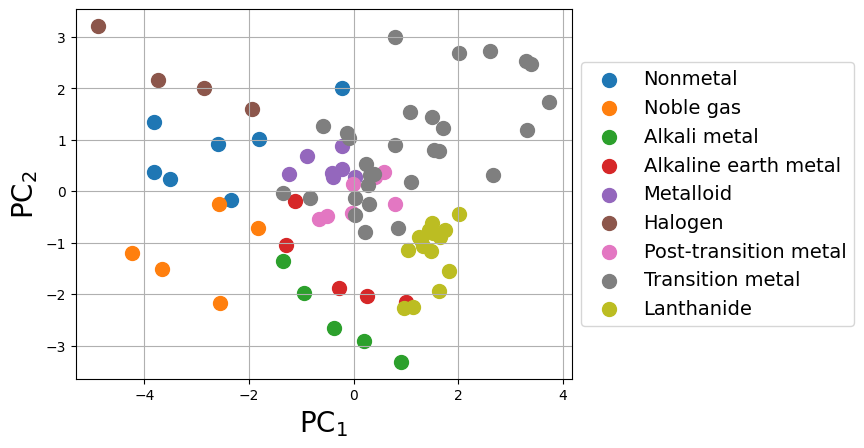

In [2]:
#load data set for chemical elements
elements_df = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture20/elements.csv')

#select our features- the numerical features AtomicMass, Electronegativity, AtomicRadius, IonizationEnergy, ElectronAffinity, MeltingPoint, BoilingPoint, Density
cols = list(elements_df.columns)
features = cols[cols.index('AtomicMass'):cols.index('Density') + 1]

#build the feature matrix
X = elements_df[features]

#get the labels
y = elements_df['GroupBlock']

#standardize the features- necessary for PCA
scaler = sklearn.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

#make a PCA object and perform PCA on the scaled features
pca = sklearn.decomposition.PCA(n_components=2)
PCs = pca.fit_transform(X_scaled)

#plot the projected data colored by the periodic table group
categories = elements_df['GroupBlock'].unique() #get the unique labels in the 'GroupBlock'
colors = plt.cm.tab10.colors[:len(categories)] #set up a color for each unique label

fig,ax = plt.subplots()
for cat, col in zip(categories, colors): #loop over all of the unique labels
    indices = (elements_df['GroupBlock'] == cat).values #get all of the data points with this label
    ax.scatter(PCs[indices, 0], PCs[indices, 1], s=100, label=cat, color=col) #plot all of the data points with this label

ax.set_xlabel('$\\mathrm{PC_{1}}$',fontsize=20)
ax.set_ylabel('$\\mathrm{PC_{2}}$',fontsize=20)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=14)
ax.grid()
plt.show()

# **Linear Discriminant Analysis**

Let's first use fit LDA to classify to an element into one of these periodic table groups based on $\mathrm{PC_1}$ and $\mathrm{PC_2}$.  LDA is in <code>sklearn</code> as <code>discriminant_analysis.LinearDiscriminantAnalysis</code>.  If we want to use the fitted covariance matrices later we feed in the keyword <code>store_covariance=True</code>.

Notice that I'm using the categorical data directly.  The $y$ vector here is a vector of strings with the name of the periodic group for each element.  <code>sklearn</code> can take this data directly and encode it automatically with each category as a unique integer.

In [3]:
#fit an LDA model
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(PCs, y)

#get the training accuracy of LDA
y_pred = lda.predict(PCs)
accuracy = sklearn.metrics.accuracy_score(y, y_pred)
print('Training accuracy:', np.round(100.0*accuracy, decimals=2),'%')

Training accuracy: 71.43 %


We can also visualize the decision boundaries with our data.

In [4]:
def plot_decision_boundaries(X, y, model):
  #grid of test points
  x_min = np.min(X[:,0])
  x_max = np.max(X[:,0])
  y_min = np.min(X[:,1])
  y_max = np.max(X[:,1])
  XX, YY = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
  grid_points = np.c_[XX.ravel(), YY.ravel()]

  #map labels to integers
  classes = list(model.classes_)
  label_to_int = {label: i for i, label in enumerate(classes)}

  #map labels to colors
  colors = plt.cm.tab10.colors[:len(classes)]
  label_to_color = {label: color for label, color in zip(classes, colors)}
  colormap = matplotlib.colors.ListedColormap([label_to_color[cls] for cls in classes])

  #predict at each test point
  ZZ = model.predict(grid_points)

  #convert label predictions (ZZ) into integers (ZZ_int) for plotting purposes
  ZZ_int = np.vectorize(label_to_int.get)(ZZ).reshape(XX.shape)

  #plot the decision boundaries with a contour
  fig, ax = plt.subplots()
  ax.pcolormesh(XX, YY, ZZ_int, cmap=colormap, alpha=0.5)

  #plot the data points with consistent colors
  for cat in classes: #loop over all of the unique labels
      indices = (y == cat).values #get all of the data points with this label
      ax.scatter(X[indices, 0], X[indices, 1], s=100, label=cat, color=label_to_color[cat]) #plot all of the data points with this label

  ax.set_xlabel('$\\mathrm{PC_{1}}$',fontsize=20)
  ax.set_ylabel('$\\mathrm{PC_{2}}$',fontsize=20)
  ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=14)

  ax.grid()
  plt.show()

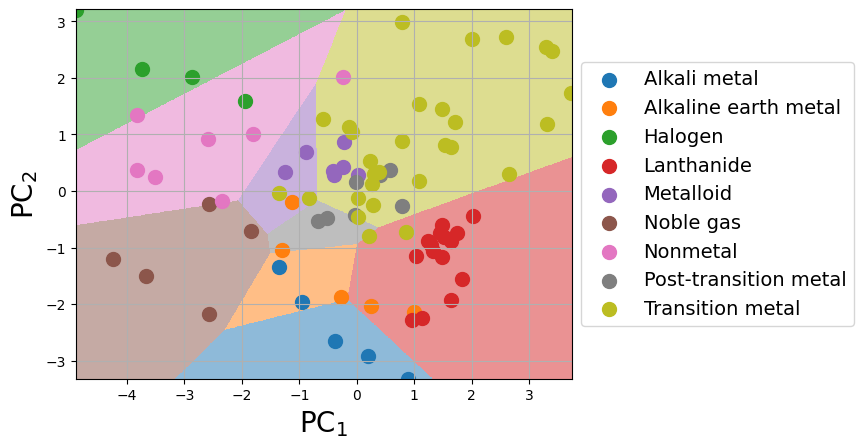

In [5]:
plot_decision_boundaries(PCs, y, lda)

We can also visualize the underlying multivariate Gaussians for each class.

In [6]:
def plot_gaussians(X, y, model):
  #grid of test points
  x_min = np.min(X[:,0])
  x_max = np.max(X[:,0])
  y_min = np.min(X[:,1])
  y_max = np.max(X[:,1])
  XX, YY = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
  grid_points = np.c_[XX.ravel(), YY.ravel()]

  #get the classes and means and covariance matrices for each
  classes = list(model.classes_)
  means = model.means_

  #this is a way to re-use this function for LDA and QDA
  #because QDA has several covariance matrices and LDA only has one, we'll repeat the LDA covariance matrix
  covs = None
  if isinstance(model, sklearn.discriminant_analysis.LinearDiscriminantAnalysis):
    covs = [model.covariance_] * len(classes)
  elif isinstance(model, sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis):
    covs = model.covariance_
  else:
    raise ValueError("Model must be an instance of LDA or QDA!")

  #map labels to colors
  colors = plt.cm.tab10.colors[:len(classes)]

  fig,ax = plt.subplots()

  #plot each of the Gaussians as a contour
  for mean, cov, label, color in zip(means, covs, classes, colors):
    rv = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    ZZ = rv.pdf(grid_points).reshape(XX.shape)
    ax.contour(XX, YY, ZZ, levels=5, colors=[color], alpha=0.8, linewidths=1.5)

  #plot the data points with consistent colors
  for cat,col in zip(classes,colors): #loop over all of the unique labels
      indices = (y == cat).values #get all of the data points with this label
      ax.scatter(X[indices, 0], X[indices, 1], s=100, label=cat, color=col) #plot all of the data points with this label

  ax.set_xlabel('$\\mathrm{PC_{1}}$',fontsize=20)
  ax.set_ylabel('$\\mathrm{PC_{2}}$',fontsize=20)
  ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=14)

  ax.grid()
  plt.show()

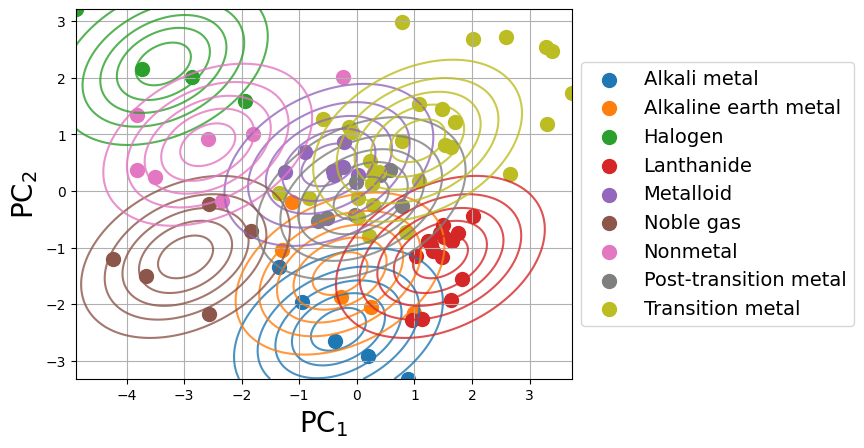

In [7]:
plot_gaussians(PCs, y, lda)

# **Quadratic Discriminant Analysis**

Let's now try QDA.  The main difference from LDA is that we now estimate a covariance matrix for each class.  With LDA we had the same covariance matrix across all classes.  QDA is in <code>sklearn</code> as <code>discriminant_analysis.QuadraticDiscriminantAnalysis</code> and we'll still use <code>store_covariance=True</code> to store the covariance matrices for later analysis.

In [8]:
#fit a QDA model
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(PCs, y)

#get the training accuracy of LDA
y_pred = qda.predict(PCs)
accuracy = sklearn.metrics.accuracy_score(y, y_pred)
print('Training accuracy:', np.round(100.0*accuracy, decimals=2),'%')

Training accuracy: 85.71 %


We can already see that the training accuracy has increased!  Let's look at those decision boundaries.

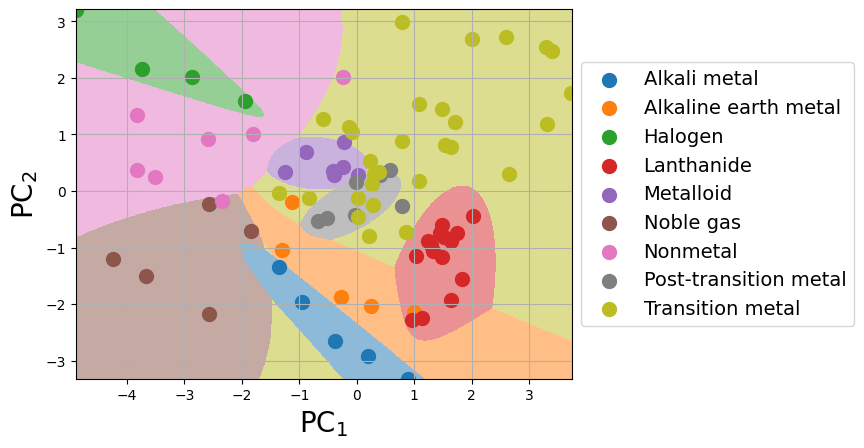

In [9]:
plot_decision_boundaries(PCs, y, qda)

With LDA all of our decision boundaries are linear.  With QDA they can now be curved and this helps to really separate classes with non-linear boundaries and even classes that are enclaved inside another class.

Finally, let's look at the underlying Gaussians here.

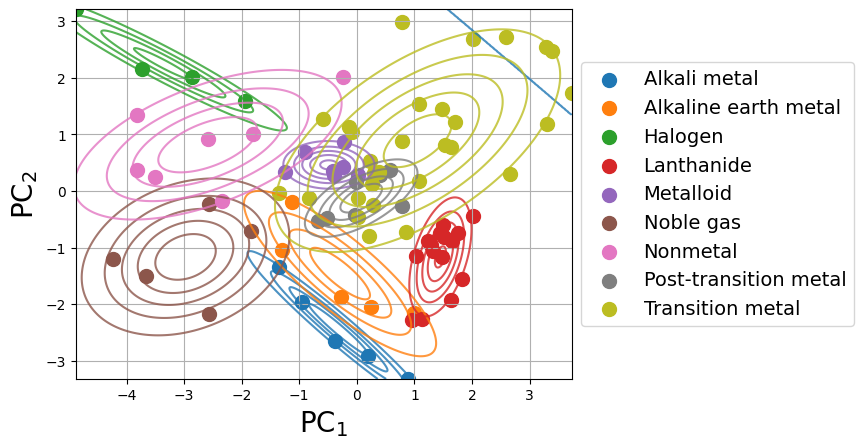

In [10]:
plot_gaussians(PCs, y, qda)

As we can see in this case, having an individual covariance matrix for each class helps a lot.  Some class have negative correlation, some have positive.  Some of the correlations are strong and some are weak.  QDA gives us the flexibility to treat each individually.